# RNN exercise

This exercise will use data from the Federal Reserve Economic Database (FRED) oncerning Electricity and Gas Utilities Production from January 1992 to January 2019 (325 records)

The sourse of the data can be found [here](https://fred.stlouisfed.org/series/IPG2211A2N)

The following code will be divided in the next topics:

- Imports and loading data
- Preprocessing
- Definition of the RNN architecture, instantiation and define criterion & optimization
- Training
- Evaluation over test data
- Plots of the model

--------

## Imports and loadings

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly as px
import os
import torch
import torch.nn as nn
import torch.nn.functional as F

from time import time
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import MinMaxScaler


# Environment settings
register_matplotlib_converters()
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [4]:
# Loading data
df = pd.read_csv('../Course Resources/Data/TimeSeriesData/Energy_Production.csv', index_col=0, parse_dates=True)

print(len(df))
df.head()

325


,IPG2211A2N
DATE,
1992-01-01,85.5560
1992-02-01,80.4178
1992-03-01,74.7390
1992-04-01,69.8367
1992-05-01,67.3781


In [5]:
# Assert there are not na values
df.dropna(inplace=True)
# Check if we drop na values
print(len(df))

325


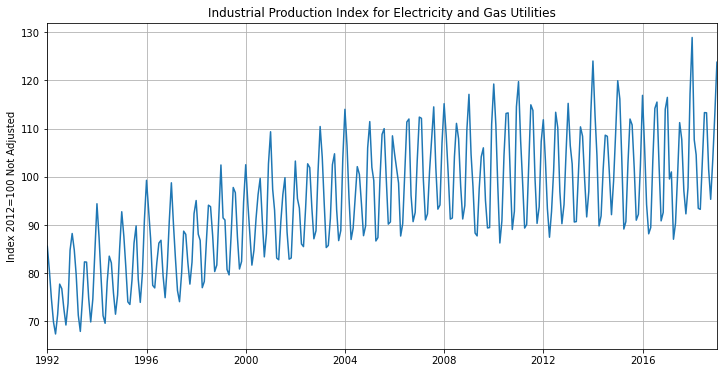

In [8]:
# Plot of the data
plt.figure(figsize=(12, 6))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100 Not Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N'])
plt.show()

-------

## Data processing

First step will be create a training and testing batches.

We will use a window of 12 months, so we will have a full year to test our model.

In [9]:
# Checking the datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 325 entries, 1992-01-01 to 2019-01-01
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   IPG2211A2N  325 non-null    float64
dtypes: float64(1)
memory usage: 5.1 KB


In [12]:
# Divide data to training and testing.
y = df['IPG2211A2N'].values # The values are actually float64

# Splitting the data into testing and training
test_size = 12 # Months
window = 12

training_set = y[:-test_size]
testing_set = y[-test_size:]

# Check sizes
print(f"Training size: {len(training_set)}")
print(f"Testing size: {len(testing_set)}")

Training size: 313
Testing size: 12


### Normalizing sets with MinMax

Remember that this kind of normalization helps with data leakage and to converge faster. The range is from [-1, 1]

In [13]:
# fit and training the scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

train_norm = scaler.fit_transform((training_set.reshape(-1, 1)))
train_norm

array([[-0.4091274 ],
       [-0.57614458],
       [-0.76073396],
       [-0.92008321],
       [-1.        ],
       [-0.8686278 ],
       [-0.66363178],
       [-0.69442052],
       [-0.83129906],
       [-0.93959921],
       [-0.79393782],
       [-0.43429277],
       [-0.3222513 ],
       [-0.43396447],
       [-0.59985048],
       [-0.87339303],
       [-0.98267484],
       [-0.76686766],
       [-0.51377399],
       [-0.51526922],
       [-0.75770125],
       [-0.91881227],
       [-0.76434852],
       [-0.4445286 ],
       [-0.12159795],
       [-0.34901591],
       [-0.60678704],
       [-0.87636399],
       [-0.92799168],
       [-0.64827317],
       [-0.47502479],
       [-0.52042126],
       [-0.72240732],
       [-0.86666125],
       [-0.73679728],
       [-0.4246908 ],
       [-0.17557249],
       [-0.34050935],
       [-0.54030132],
       [-0.78326968],
       [-0.8009979 ],
       [-0.63684767],
       [-0.38681272],
       [-0.27097141],
       [-0.63054495],
       [-0

In [14]:
# Check that the convertion is really made
print(f"Original val: {training_set[0]}")
print(f"Transformed val: {train_norm[0]}")

Original val: 85.556
Transformed val: [-0.4091274]


In [15]:
# Convertion to Tensor
train_norm = torch.FloatTensor(train_norm).view(-1)

### Preparing batches for the RNN

In [16]:
# Function to create batches
def input_data(seq, ws):
    """
    Function to create batches for training.
    :param seq: Sequence of data
    :param ws: Window size
    :return: Tuple of serie and label
    """
    # Prepare output and data
    out = []
    L = len(seq) # How large is the sequence

    for i in range(L-ws):
        window = seq[i:i+ws] # datapoints
        label = seq[i+ws:i+ws+1] # The next value is the label
        out.append((window, label))

    return out


In [17]:
# Creating the batches
train_data = input_data(train_norm, ws=window)

print(f"Size of batches: {len(train_data)}")

Size of batches: 301


-----------------

## Definition of RNN model

The model will have a (1, 64) LSTM layer and a Fully connected with (64, 1) in-out.

In [22]:
# Definition of the LSTM model
class RNNmodel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, output_size=1):
        super().__init__()
        # Creating the hidden size
        self.hidden_size = hidden_size
        # Defining the model
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size)
        # Fully Connected
        self.fc = nn.Linear(in_features=hidden_size, out_features=output_size)
        # Hidden connection to LSTM
        self.hidden = (torch.zeros(1, 1, self.hidden_size),
                       torch.zeros(1, 1, self.hidden_size))

    # Forward method
    def forward(self, seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1),
                                          self.hidden)
        pred = self.fc(lstm_out.view(len(seq), -1)) # Flattening input

        # Return just the last part
        return pred[-1]


In [23]:
# Settings
# Set seed
torch.manual_seed(101)

# Instanciate
model = RNNmodel()

# Setting criterion and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Show model
model

RNNmodel(
  (lstm): LSTM(1, 64)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [25]:
# Check number of parameters
total = 0
for param in model.parameters():
    print(param.numel())
    total += param.numel()

print("".center(40, '='))
print(f"Total: {total:,}")

256
16384
256
256
64
1
Total: 17,217


--------------

## Training the model

In [26]:
# Constants
epochs = 50
toc = time()

# Main loop
for epoch in range(epochs):
    for seq, label in train_data:
        # Zero grad
        optimizer.zero_grad()
        # Setting hidden tuple
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        # Passing data to the model
        y_pred = model(seq)

        # Getting loss and backpropagate
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()

    # Heartbeat
    print(f"Epoch: {epoch}\t\tLoss: {loss.item()}")

# Print all time
tic = time()
total_time = tic -toc
print(''.center(45, '='))
print(f"Total time: {total_time/60} min")
print(f"Total time: {total_time} segs")

Epoch: 0		Loss: 0.7314830422401428
Epoch: 1		Loss: 0.32224392890930176
Epoch: 2		Loss: 0.24065648019313812
Epoch: 3		Loss: 0.22756004333496094
Epoch: 4		Loss: 0.2115359902381897
Epoch: 5		Loss: 0.19906578958034515
Epoch: 6		Loss: 0.19067460298538208
Epoch: 7		Loss: 0.18480707705020905
Epoch: 8		Loss: 0.1796238124370575
Epoch: 9		Loss: 0.174419566988945
Epoch: 10		Loss: 0.16898848116397858
Epoch: 11		Loss: 0.16325688362121582
Epoch: 12		Loss: 0.15732835233211517
Epoch: 13		Loss: 0.1513940840959549
Epoch: 14		Loss: 0.14566253125667572
Epoch: 15		Loss: 0.14030805230140686
Epoch: 16		Loss: 0.13544116914272308
Epoch: 17		Loss: 0.13110320270061493
Epoch: 18		Loss: 0.12727925181388855
Epoch: 19		Loss: 0.12391797453165054
Epoch: 20		Loss: 0.12095386534929276
Epoch: 21		Loss: 0.11832565069198608
Epoch: 22		Loss: 0.11598339676856995
Epoch: 23		Loss: 0.11389030516147614
Epoch: 24		Loss: 0.11202088743448257
Epoch: 25		Loss: 0.110361747443676
Epoch: 26		Loss: 0.10891446471214294
Epoch: 27		Loss: 0.

--------

## Evaluation of the model

### First we will evaluate over the known future

In [28]:
# Setting how many months in future we will check
future = 12
# Get a list with the last 12 months
preds = train_norm[-future:].tolist()

# Setting model to evaluation
model.eval()

for i in range(future):
    # Getting the sequence
    seq = torch.FloatTensor(preds[-window:])

    # Deactivate grads
    with torch.no_grad():
        # Setting hidden layer
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        # Making predictions
        preds.append(model(seq).item())

# Check the predicted values
# We have the previous 12 but we want the new ones.
preds[window:]

[0.2540279030799866,
 -0.002775197848677635,
 -0.34294822812080383,
 -0.2116757333278656,
 0.2391887605190277,
 0.4891482889652252,
 0.24707992374897003,
 -0.08662214130163193,
 -0.2578176259994507,
 0.02258598431944847,
 0.5441880226135254,
 0.6110795140266418]

### Returning the data to their original state

In [31]:
# Returning the predictions to their true domain
# Sklearn expects an array of 2-D. If we don't pass it will raise
# An error. That's why we convert to numpy and reshape
true_predictions = scaler.inverse_transform(np.array(preds[window:]).reshape(-1, 1))
true_predictions

array([[105.95764142],
       [ 98.05722243],
       [ 87.59196924],
       [ 91.6305019 ],
       [105.50112262],
       [113.19100254],
       [105.74389031],
       [ 95.47771313],
       [ 90.21096964],
       [ 98.83744651],
       [114.88427242],
       [116.94215571]])

In [32]:
# Check the last 12 months from the original data
df['IPG2211A2N'][-window:]

DATE
2018-02-01    107.6711
2018-03-01    104.5716
2018-04-01     93.4491
2018-05-01     93.2405
2018-06-01    103.3083
2018-07-01    113.3178
2018-08-01    113.2758
2018-09-01    101.5656
2018-10-01     95.3203
2018-11-01    103.5750
2018-12-01    112.9498
2019-01-01    123.7687
Name: IPG2211A2N, dtype: float64

-------------

## Plot the results


In [33]:
# Create the dates for predicted data
x = np.arange('2018-02-01', '2019-02-01', dtype='datetime64[M]')
x

array(['2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
       '2018-08', '2018-09', '2018-10', '2018-11', '2018-12', '2019-01'],
      dtype='datetime64[M]')

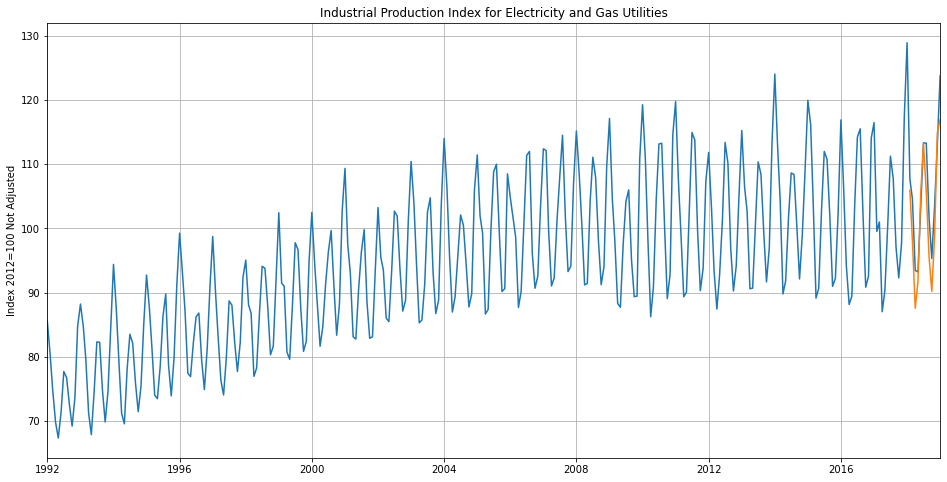

In [34]:
# Plot
plt.figure(figsize=(16, 8))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100 Not Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x, true_predictions)
plt.show()

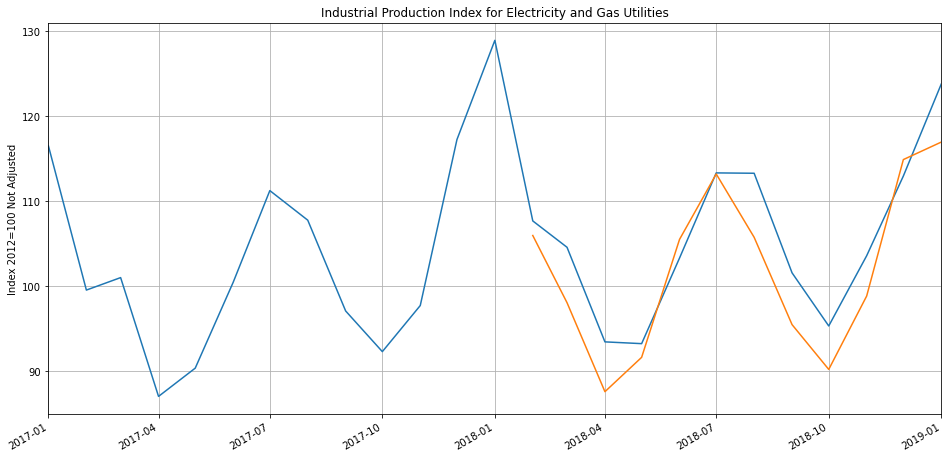

In [35]:
# A little zoom to the predicted data
# Plot
fig = plt.figure(figsize=(16, 8))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100 Not Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
fig.autofmt_xdate()

plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x, true_predictions)
plt.show()

------------

## Forecasting to the unknown future

In [36]:
# Train with all the data
# Constants
epochs = 80

# Setting model to training
model.train()

# Setting all data
# Transform with all the data
y_norm = scaler.fit_transform(y.reshape(-1, 1))
y_norm = torch.FloatTensor(y_norm).view(-1)
all_data = input_data(y_norm, window)

# Setting timer
toc = time()

# Main loop
for epoch in range(epochs):
    for seq, label in all_data:
        # Zero grad
        optimizer.zero_grad()
        # Setting hidden tuple
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))
        # Passing data to the model
        y_pred = model(seq)

        # Getting loss and backpropagate
        loss = criterion(y_pred, label)
        loss.backward()
        optimizer.step()

    # Heartbeat
    print(f"Epoch: {epoch}\t\tLoss: {loss.item():4.10}")

# Print all time
tic = time()
total_time = tic -toc
print(''.center(45, '='))
print(f"Total time: {total_time/60} min")
print(f"Total time: {total_time} segs")

Epoch: 0		Loss: 0.006224209908
Epoch: 1		Loss: 0.005867617205
Epoch: 2		Loss: 0.006210383028
Epoch: 3		Loss: 0.006752723362
Epoch: 4		Loss: 0.007290521171
Epoch: 5		Loss: 0.00778504042
Epoch: 6		Loss: 0.008224667981
Epoch: 7		Loss: 0.008612032048
Epoch: 8		Loss: 0.008958650753
Epoch: 9		Loss: 0.009278317913
Epoch: 10		Loss: 0.009583505802
Epoch: 11		Loss: 0.009883283637
Epoch: 12		Loss: 0.01018256508
Epoch: 13		Loss: 0.01048133057
Epoch: 14		Loss: 0.0107734371
Epoch: 15		Loss: 0.01104443893
Epoch: 16		Loss: 0.01126757637
Epoch: 17		Loss: 0.01139667165
Epoch: 18		Loss: 0.0113582965
Epoch: 19		Loss: 0.01105779782
Epoch: 20		Loss: 0.01044537034
Epoch: 21		Loss: 0.00964503549
Epoch: 22		Loss: 0.008909557015
Epoch: 23		Loss: 0.008346121758
Epoch: 24		Loss: 0.007876414806
Epoch: 25		Loss: 0.007393031381
Epoch: 26		Loss: 0.006838671397
Epoch: 27		Loss: 0.006201883778
Epoch: 28		Loss: 0.00549534522
Epoch: 29		Loss: 0.004742905498
Epoch: 30		Loss: 0.003973254934
Epoch: 31		Loss: 0.003215348581


## Forecasting the unknown future


In [68]:
# Settings
window = 24
future = 24
L = len(y) # All the data

# Getting the last 12 points
preds = y[-window:].tolist()

# settting evaluation mode
model.eval()

# Main loop
for i in range(future):
    # Getting seq
    seq = torch.FloatTensor(preds[-window:])

    # Deactivate zero grad
    with torch.no_grad():
        # Setting hidden layer
        model.hidden = (torch.zeros(1, 1, model.hidden_size),
                        torch.zeros(1, 1, model.hidden_size))

        # Predicting and saving
        preds.append(model(seq).item())

# Returning data to their domain
true_predictions = scaler.inverse_transform(np.array(preds).reshape(-1, 1))
# Show preds
true_predictions

array([[3160.41939485],
       [3205.55091635],
       [2775.8046923 ],
       [2877.99513195],
       [3188.1658974 ],
       [3520.29636295],
       [3413.27282035],
       [3084.80025385],
       [2937.767479  ],
       [3104.4926103 ],
       [3704.90182165],
       [4063.90507795],
       [3410.59015595],
       [3315.2355882 ],
       [2973.05743695],
       [2966.63996225],
       [3276.37079535],
       [3584.3080581 ],
       [3583.0159491 ],
       [3222.7575012 ],
       [3030.62396935],
       [3284.5756875 ],
       [3572.9867221 ],
       [3905.82477115],
       [ 120.15880252],
       [ 106.18526224],
       [ 105.6877202 ],
       [ 101.06714231],
       [  96.04769462],
       [  93.52033464],
       [  91.31383627],
       [ 100.17921641],
       [ 112.16092949],
       [ 113.50677698],
       [ 108.37089531],
       [  99.95021631],
       [  86.54734665],
       [  92.08744337],
       [ 101.52478609],
       [ 113.22458046],
       [ 114.36653072],
       [ 113.706

## Plotting the future

In [97]:
# Create the dates for predicted data
x = np.arange('2019-02-01', '2021-02-01', dtype='datetime64[M]')
x

array(['2019-02', '2019-03', '2019-04', '2019-05', '2019-06', '2019-07',
       '2019-08', '2019-09', '2019-10', '2019-11', '2019-12', '2020-01',
       '2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07',
       '2020-08', '2020-09', '2020-10', '2020-11', '2020-12', '2021-01'],
      dtype='datetime64[M]')

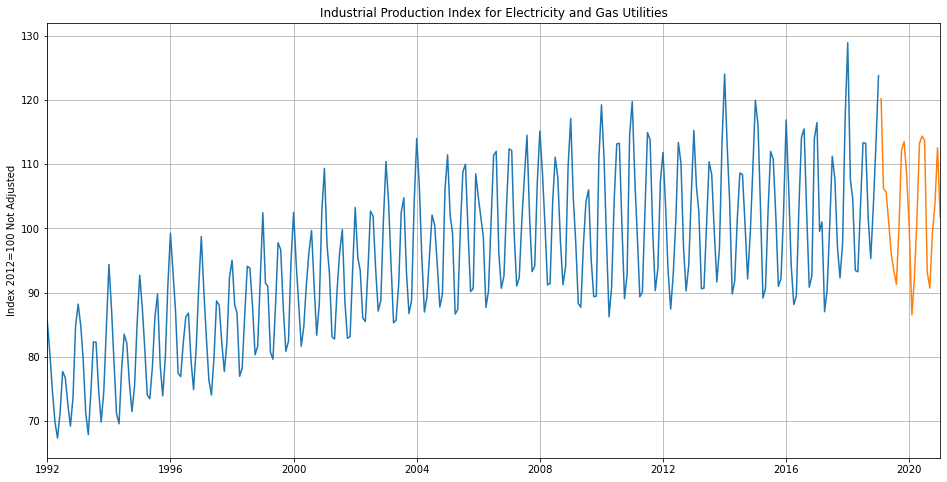

In [98]:
# Plot
plt.figure(figsize=(16, 8))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100 Not Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N'])
plt.plot(x, true_predictions[window:])
plt.show()

ValueError: x and y must have same first dimension, but have shapes (48,) and (24, 1)

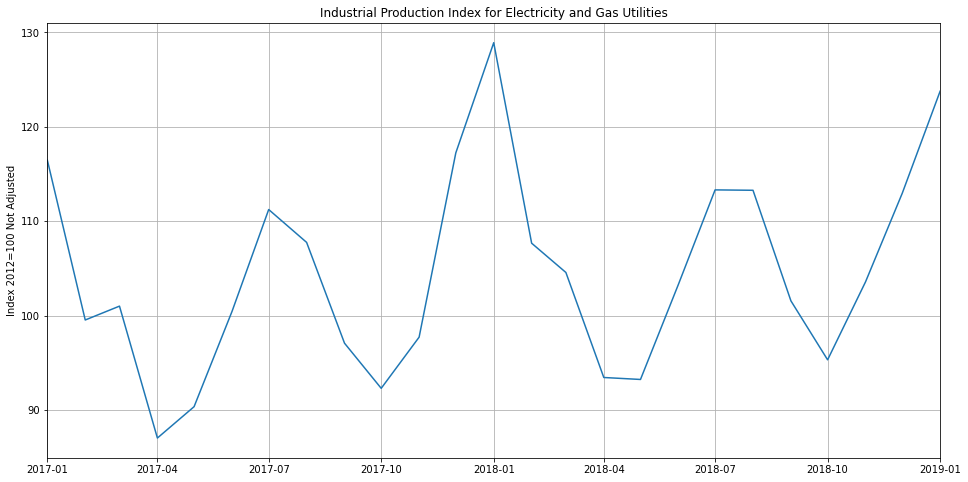

In [93]:
# Plot zoom
fig = plt.figure(figsize=(16, 8))
plt.title('Industrial Production Index for Electricity and Gas Utilities')
plt.ylabel('Index 2012=100 Not Adjusted')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(df['IPG2211A2N']['2017-01-01':])
plt.plot(x, true_predictions[window:])
plt.show()